In [1]:
import numpy as np
from skimage import io
from utils import grainPreprocess, grainMark
from numpy.lib.stride_tricks import sliding_window_view

from matplotlib import pyplot as plt

from skimage import io, color, filters, morphology, util
from skimage.measure import EllipseModel
from skimage.color import rgb2gray
from skimage import filters, util
from skimage.morphology import disk, skeletonize, ball
from skimage.measure import approximate_polygon
from skimage import transform
import copy
from PIL import Image, ImageDraw, ImageFilter, ImageOps

from matplotlib import cm
import networkx as nx
from tqdm.notebook import tqdm

from bresenham import bresenham
import pandas as pd

from shapely.geometry import Polygon
import rasterio.features
import matplotlib.pyplot as plt

from networkx.drawing import draw_networkx

In [2]:
def draw_contours(image, cnts, color=(0, 139, 139), r=4, e_width=5, l_width=4):

    img = copy.copy(image)
    draw = ImageDraw.Draw(img)

    for j, cnt in enumerate(cnts):
        if len(cnt) > 1:
            point = cnt[0]
            x1, y1 = point[1], point[0]

            for i, point2 in enumerate(cnt):
                p2 = point2

                x2, y2 = p2[1], p2[0]

                draw.ellipse((y2 - r, x2 - r, y2 + r, x2 + r), fill=color, width=e_width)
                draw.line((y1, x1, y2, x2), fill=(255, 140, 0), width=l_width)
                x1, y1 = x2, y2

    return img


def draw_edges(image, cnts, color=255, r=4, e_width=5, l_width=4):
    
    img = copy.copy(Image.fromarray(image))
    draw = ImageDraw.Draw(img)

    for j, cnt in enumerate(cnts):
        if len(cnt) > 1:
            point = cnt[0]
            x1, y1 = point[1], point[0]
            for i, point2 in enumerate(cnt):
                p2 = point2
                x2, y2 = p2[1], p2[0]

                draw.line((y1, x1, y2, x2), fill=color, width=l_width)
                x1, y1 = x2, y2

    return img


def preprocess_image_1(image):
    if len(image.shape)==3:
        image = color.rgb2gray(image)

    image = filters.rank.median(image, morphology.disk(3))

    global_thresh = filters.threshold_otsu(image)
    image = image > global_thresh
    binary = image*255
    binary = binary.astype(np.uint8)

    grad = abs(filters.rank.gradient(binary, morphology.disk(1)))
    bin_grad = (1 - binary + grad) * 127
    bin_grad = np.clip(bin_grad, 0, 255).astype(np.uint8)

    return bin_grad

def align_figures(img_viz):
    cnts=grainMark.get_contours(img_viz,tol=tol)

    cnts = [cnt for cnt in cnts if len(cnt)>2]
    polies=[ Polygon(cnt) for cnt in cnts]

    img_viz_raster = 1 - rasterio.features.rasterize(polies, out_shape=img_viz.shape)
    img_viz_raster = img_viz_raster*127
    img_viz = img_viz_raster.astype(np.uint8)+127
    # grad = abs(filters.rank.gradient(img_viz, morphology.disk(1)))
    
    img_viz_raster = rasterio.features.rasterize(polies, out_shape=img_viz.shape).astype(np.uint8)*255
    # img_viz_raster = img_viz_raster*127
    grad = abs(filters.rank.gradient(img_viz_raster, morphology.disk(1)))
    
    img_viz = np.clip(img_viz-grad,0,255).astype(np.uint8)
    return img_viz,cnts, grad

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 255)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

In [52]:
io.imread('../datasets/original/o_bc_left/Ultra_Co6_2/Ultra_Co6_2-001.jpeg').shape

(1536, 1536)

# Plot all points

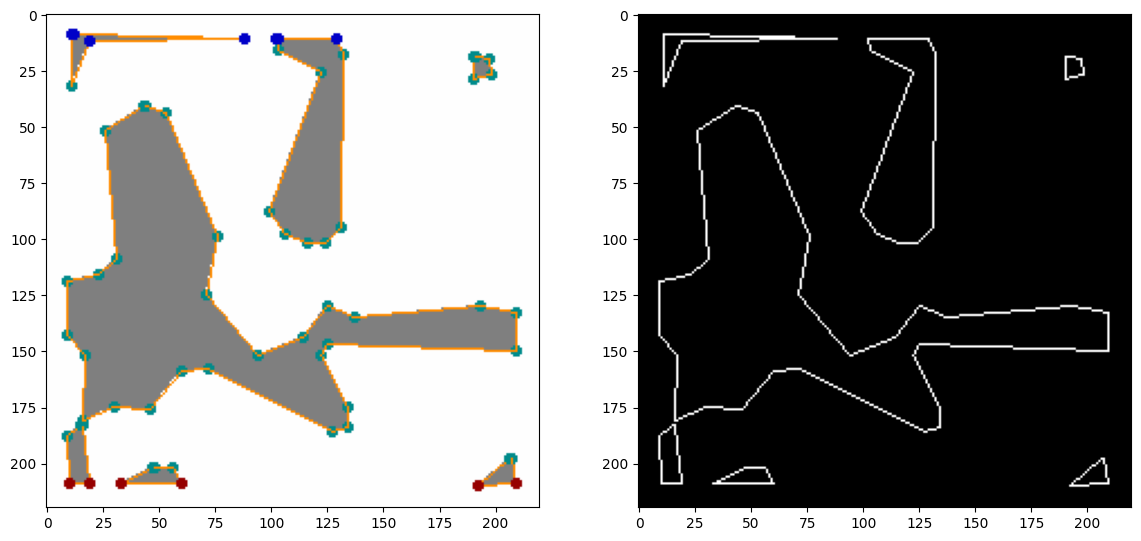

In [48]:
orig_img = io.imread('../datasets/original/o_bc_left/Ultra_Co6_2/Ultra_Co6_2-001.jpeg')[:200,:200]

r=2
eps = 15
border = 10
tol = 3
    
tmp_img = preprocess_image_1(orig_img)
orig_img_padded = np.pad(tmp_img, border, pad_with)
img_viz,cnts, grad_viz = align_figures(orig_img_padded)

img_shape=np.array(img_viz.shape)

# coord2index
image_nodes_coord2nodes_index={}
nodes_index2global_nodes_coord={}
num_of_nodes=0

for points in reversed(cnts):
    for point in points:
        x,y = point[0],point[1]
        image_nodes_coord2nodes_index[(x,y)]=num_of_nodes
        nodes_index2global_nodes_coord[num_of_nodes]=(x,y)
        num_of_nodes+=1

# entry points
entry_nodes=[]

entry_dict={}

y_entry_max=0

for points in cnts:
    for point in points:
        if point[1]<eps:
            x,y = point[0],point[1]
            # condition to make end exit poits below start points 
            if y_entry_max<y:
                y_entry_max=y
            
            index=image_nodes_coord2nodes_index[(x,y)]
            entry_dict[index]=1
            entry_nodes.append(index)

# exit points
exit_nodes=[]
exit_dict={}

for points in cnts:
    for point in points:
        # if (point[0] < eps or img_shape[0] - point[0] < eps or img_shape[1] - point[1] < eps) and point[1]>y_entry_max:
        if (img_shape[1] - point[1] < eps) and point[1]>y_entry_max:
            x,y = point[0],point[1]
            index=image_nodes_coord2nodes_index[(x,y)]
            exit_nodes.append(index)
            exit_dict[index]=1

img_drawings = copy.copy(Image.fromarray(img_viz)).convert('RGB')
img_drawings=draw_contours(img_drawings, cnts=cnts, r=2, l_width=1)
draw = ImageDraw.Draw(img_drawings)

# entry blue
for key in entry_nodes:
    x,y=nodes_index2global_nodes_coord[key]
    draw.ellipse((x - r, y - r, x + r, y + r), fill=(0,0,200), width=1)
    
# exit red
for key in exit_nodes:
    x,y=nodes_index2global_nodes_coord[key]
    draw.ellipse((x - r, y - r, x + r, y + r), fill=(150,0,0), width=1)
    
    
img_contours = draw_edges(np.zeros_like(img_viz), cnts=cnts, r=2, l_width=1)


fig,axes = plt.subplots(1,2,figsize=(14,7))

axes[0].imshow(img_drawings,cmap='gray')
axes[1].imshow(img_contours,cmap='gray')
# plt.savefig('miniature_figures_aligned.png', bbox_inches='tight')
plt.show()

In [14]:
entry_nodes.__len__()

7

In [15]:
exit_nodes.__len__()

14

tmp_img1) image_nodes_coord2nodes_index
2) nodes_index2global_nodes_coord
3) image_node_coord2node_index

1) grid_cell_coord2grid_cell_index
2) grid_cell_index2grid_cell_coord
3) image_coord2grid_cell_index

  0%|          | 0/63 [00:00<?, ?it/s]

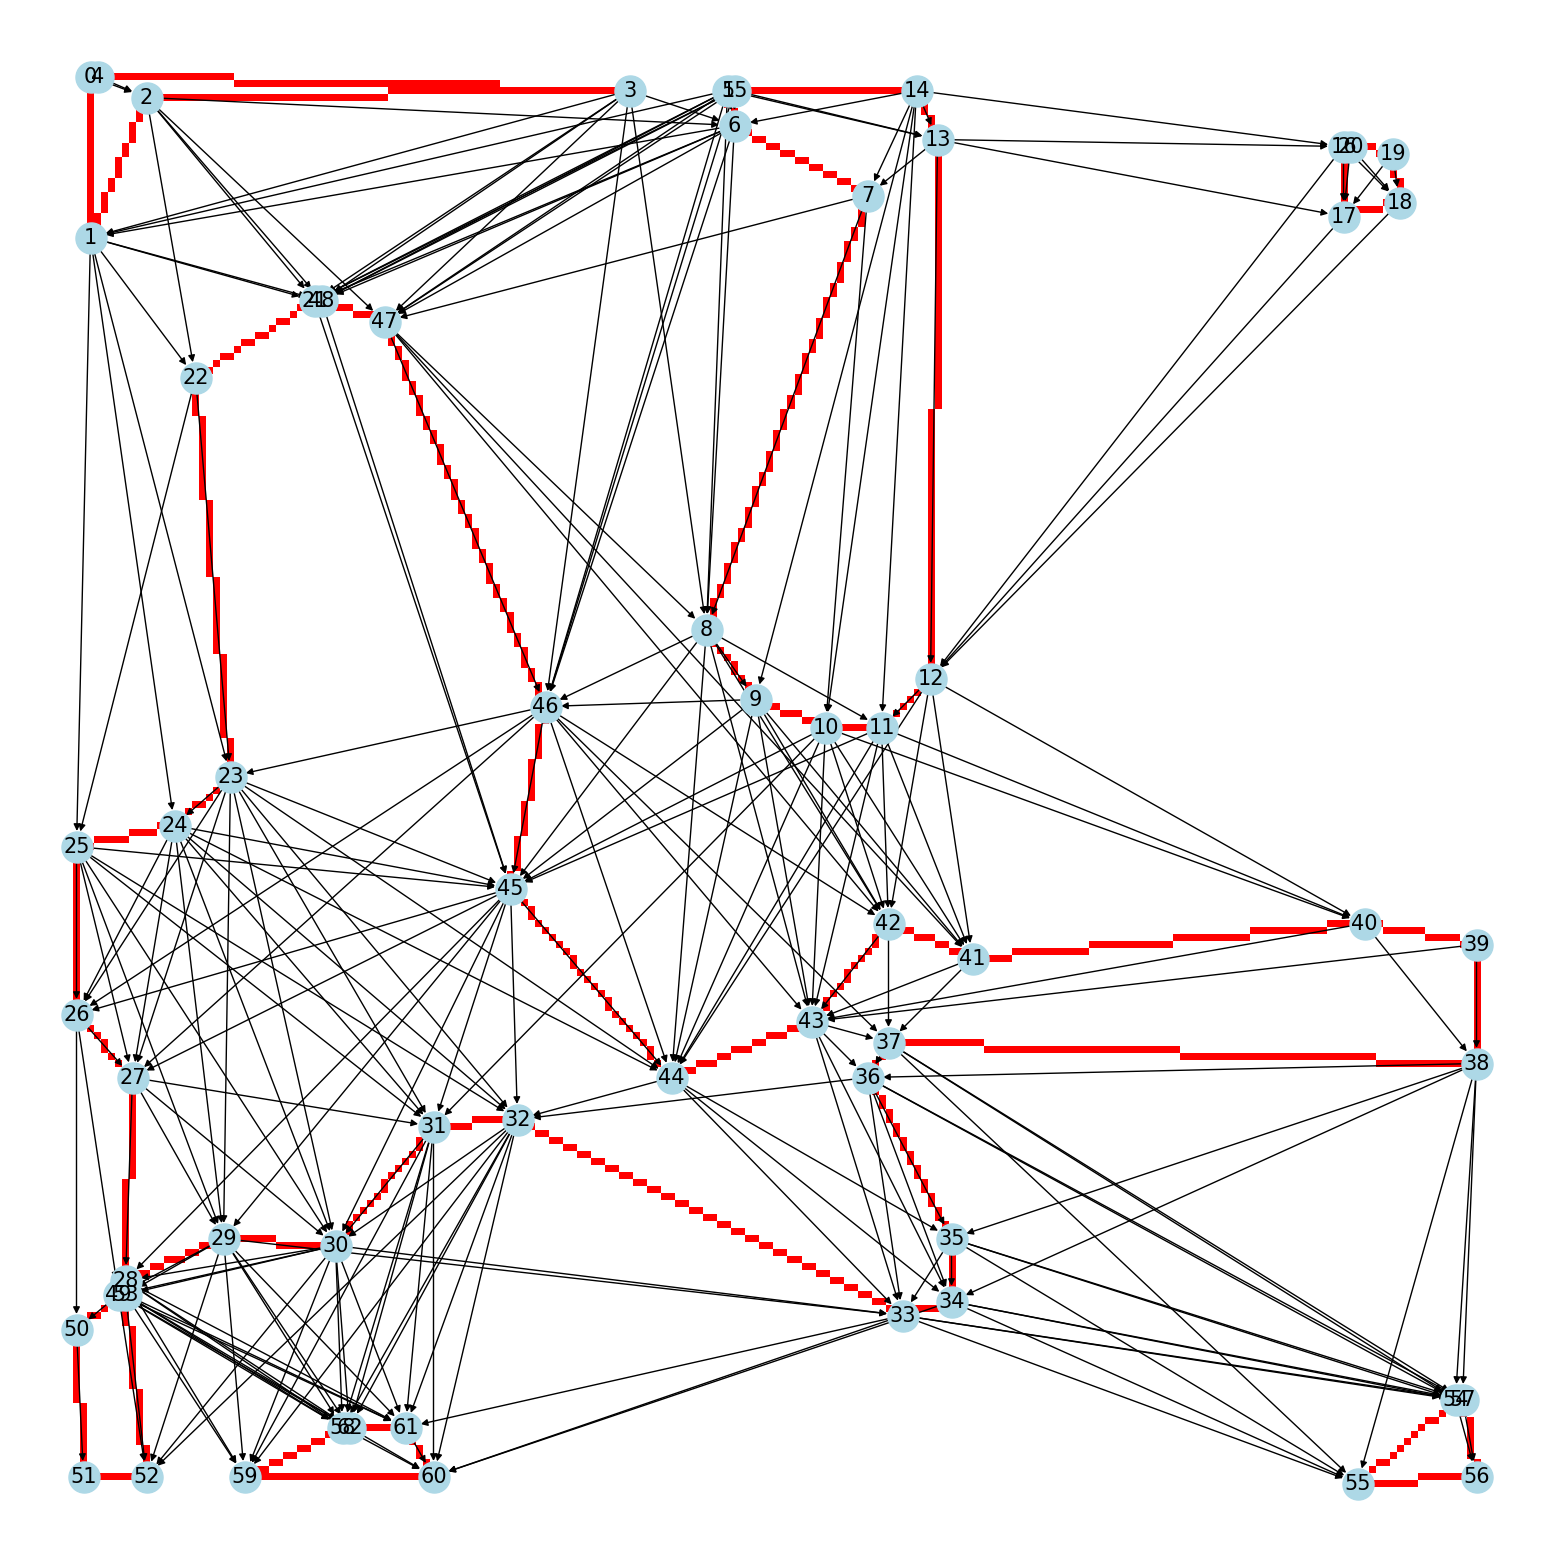

In [51]:
eps=100
line_eps = 2
border_eps = 0
border_number_min = 3
border_pixel=255
    
g = nx.DiGraph()
image_node_coord2node_index = np.zeros(img_shape,dtype=np.int32)
for key in range(num_of_nodes):
    x,y=nodes_index2global_nodes_coord[key]
    image_node_coord2node_index[x,y]=key
    g.add_node(key, pos=(x,y)) 

m=[]

img_contours_np = np.array(img_contours)

for start_node_index in tqdm(range(num_of_nodes)):
    
    # choose cell
    start_node_x,start_node_y=nodes_index2global_nodes_coord[start_node_index]
    
    # for rectangular vertical slice only!
    ###############################################
    start_node_y +=1
    
    # left x slice border
    if start_node_x-eps<0:
        left_border_x=0
    else:
        left_border_x=start_node_x-eps-2

    # right x slice border
    if start_node_x+eps>image_node_coord2node_index.shape[0]:
        right_border_x=image_node_coord2node_index.shape[0]
    else:
        right_border_x=start_node_x+eps+2

    # upper_border
    if start_node_y+eps>image_node_coord2node_index.shape[1]-1:
        upper_border=image_node_coord2node_index.shape[1]-1
    else:
        upper_border=start_node_y+eps
        
    map_slice = image_node_coord2node_index[left_border_x:right_border_x,start_node_y:upper_border]
    ###############################################
    
    nodes_indices_indices = np.where(map_slice.flatten()!=0)
    nodes_indices = map_slice.flatten()[nodes_indices_indices]
    
    # next node search
    for node_index in nodes_indices:
        end_node_x,end_node_y=nodes_index2global_nodes_coord[node_index]
        
        mean_border_pixels=0
        for p in range(0 - line_eps, 1 + line_eps):
            line_coords=np.array(list(bresenham(start_node_x+p, start_node_y,end_node_x+p, end_node_y)))
            line_coords_pixels=img_contours_np[line_coords[:,1],line_coords[:,0]][2:-2]
            border_pixels_num = np.where(line_coords_pixels==border_pixel)[0].shape[0]
            if border_pixels_num<=border_eps:
                mean_border_pixels+=1
            
        # m.extend(mean_border_pixels)
        # line_border_pixels_mean=np.mean(mean_border_pixels)
        if mean_border_pixels>=border_number_min and start_node_index!=node_index:
            g.add_edge(start_node_index,node_index, weight=np.linalg.norm((end_node_x-start_node_x, end_node_y-start_node_y)))
        # m.append(np.mean(mean_pixels))


img_tmp = img_contours.convert('RGB')
img_tmp = 255 - np.array(img_tmp)
dark_pixels = img_tmp[:,:,0]==0
img_tmp[dark_pixels]=[255,0,0]
        
pos = nx.get_node_attributes(g, 'pos')
fig,axes = plt.subplots(1,1,figsize=(40,20))

nx.draw(g, pos,ax =axes,  with_labels=True, node_color='lightblue', node_size=500, font_size=15)
axes.imshow(img_tmp, cmap='gray')

# axes[0].invert_yaxis()
# axes[1].invert_yaxis()
plt.savefig('graph.jpg',bbox_inches='tight')
plt.show()

In [ ]:
def getPerpCoord(aX, aY, bX, bY, length):
    vX = bX-aX
    vY = bY-aY
    
    mag = math.sqrt(vX*vX + vY*vY)
    vX = vX / mag
    vY = vY / mag
    temp = vX
    vX = 0-vY
    vY = temp
    cX = bX + vX * length
    cY = bY + vY * length
    dX = bX - vX * length
    dY = bY - vY * length
    return int(cX), int(cY), int(dX), int(dY)

In [29]:
img_contours_np[line_coords[:,1],line_coords[:,0]].shape

(95,)

In [17]:
img_contours_np

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
g.has_edge(55,40)

In [ ]:
# import pickle

# # save graph object to file
# pickle.dump(g, open('g.pickle', 'wb'))

In [6]:
border_eps=0
border_number_min = 2

start_node_x, start_node_y=nodes_index2global_nodes_coord[29]

for node_index in [2]:
    end_node_x,end_node_y=nodes_index2global_nodes_coord[node_index]

    mean_border_pixels=0
    for p in range(0 - line_eps, 1 + line_eps):
        line_coords=np.array(list(bresenham(start_node_x+p, start_node_y,end_node_x+p, end_node_y)))
        line_coords_pixels=img_contours_np[line_coords[:,1],line_coords[:,0]][2:-2]
        border_pixels_num = np.where(line_coords_pixels==border_pixel)[0].shape[0]
        print(border_pixels_num)
        
        if border_pixels_num<=border_eps:
            mean_border_pixels+=1

    if mean_border_pixels>=border_number_min:
        print('added')
        g.add_edge(start_node_index,node_index)
    # m.append(np.mean(mean_pixels))

0
1
1
0
1
added


In [ ]:
# img_tmp=copy.copy(img_contours_np)
# img_tmp[line_coords[:,1],line_coords[:,0]]=255

# plt.imshow(img_tmp)

In [ ]:
mean_border_pixels

# Graph traversal

In [56]:
%%time

lengths=[]
for entry_point in tqdm(entry_nodes):
    for exit_point in exit_nodes:
        paths=list(nx.all_simple_paths(g, source=entry_point, target=exit_nodes))
        for path in paths:
            edges = np.vstack([path[:-1],path[1:]]).T
            l=0
            for edge in edges:
                edge_length=g.get_edge_data(edge[0],edge[1])['weight']
                l+=edge_length
            lengths.append(l)

  0%|          | 0/7 [00:00<?, ?it/s]

CPU times: user 1min 25s, sys: 4.18 ms, total: 1min 25s
Wall time: 1min 26s


In [40]:
path

[47, 55, 43, 54, 33, 31, 8, 7]

In [41]:
for edge in np.vstack([path[:-1],path[1:]]).T:
    print(edge)

[47 55]
[55 43]
[43 54]
[54 33]
[33 31]
[31  8]
[8 7]


In [39]:
edge

array([8, 7])

In [44]:
g.get_edge_data(edge[0],edge[1])['weight']

10.198039027185569

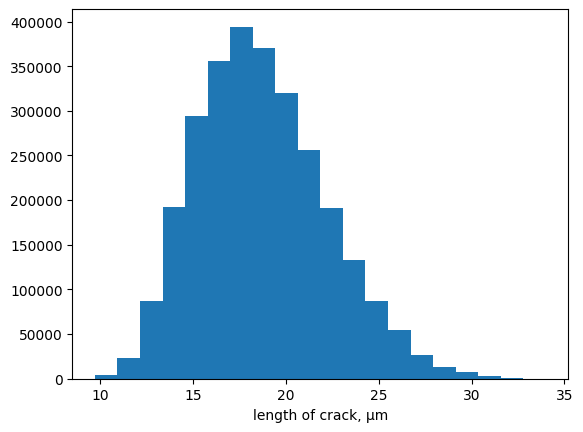

CPU times: user 278 ms, sys: 133 ms, total: 411 ms
Wall time: 264 ms


In [57]:
%%time

pixel = 50 / 1000

lengths_adjusted=np.array(lengths)*pixel

plt.hist(lengths_adjusted,bins=20)
plt.xlabel('length of crack, μm')
plt.savefig('entry_exit_paths.jpg', bbox_inches='tight')
plt.show()

In [ ]:
import math
import os
import time
from itertools import batched
from multiprocessing import Manager, Process, Queue
from queue import Empty
import pickle

import pandas as pd

from clear_terminal import clear

TQueue = list[tuple[int, set[int]]]
TResults = list[set[int]]
TAdjDict = dict[int, list[int]]


def breath_step(
        node: int,
        current_path: set[int],
        adj_dict: TAdjDict,
        stop_node: int,
        ) -> tuple[TQueue, TResults]:
    """One step to fill queue from node."""
    current_path = current_path | {node}
    results = []
    queue = []
    for neighbour in adj_dict[node]:
        if neighbour in current_path:
            continue
        if neighbour == stop_node:
            results.append(current_path | {neighbour})
        else:
            queue.append((neighbour, current_path.copy()))
    return queue, results


def process_queue(queue: TQueue, adj_dict: TAdjDict, stop_node: int) -> tuple[TQueue, TResults]:
    """Process queue and generate next queue and results."""
    next_queue = []
    results = []

    for node, current_path in queue:
        qu, res = breath_step(node, current_path, adj_dict, stop_node)
        next_queue.extend(qu)
        results.extend(res)
    return next_queue, results


def process(
        queue: Queue,
        res_queue: Queue,
        adj_dict: TAdjDict,
        stop_node: int,
        max_size: int,
        proc_state: dict
        ) -> TResults:
    # while done_flag.value == 0:
    pid = os.getpid()
    proc_state[pid] = ('STARTING', None, None)
    processed = 0
    results = []
    next_queue = []

    while True:
        proc_state[pid] = ('GET  ', 0, len(results))
        try:
            next_queue = queue.get(block=True, timeout=0.1)
        except Empty:
            # print(f"Proc {pid} in panic, QUITS")
            break
        proc_state[pid] = ('PROC ', len(next_queue), len(results))

        while 0 < len(next_queue) <= max_size:
            next_queue, res = process_queue(next_queue, adj_dict, stop_node)
            results.extend(res)

        proc_state[pid] = ('SPLIT', len(next_queue), len(results))

        processed += 1
        # print(f"Proc {pid}, {processed=}, {len(results)=}, {len(next_queue)=}")
        if next_queue:
            for q in batched(next_queue, math.ceil(max_size / 2)):
                if queue.full():
                    proc_state[pid] = ('PANIC', None, None)
                    return
                queue.put(q, timeout=2)

    proc_state[pid] = ('QUIT ', None, len(results))
    res_queue.put(results)


def update_state(state_df: pd.DataFrame, process_states: dict[str, tuple[str, int | None, int | None]]) -> pd.DataFrame:
    for pid, data in dict(process_state).items():
        state_df.loc[pid] = data
    if -1 in state_df.index and state_df.shape[0] > 1:
        state_df.drop(index=-1, axis='index', inplace=True)
    return state_df


def print_state_table(state_df: pd.DataFrame) -> None:
    print("\033[0;0H")
    print(state_df)


if __name__ == "__main__":
    START_NODE = 61
    END_NODE = 18
    N_PROCESSES = 6
    MAX_SIZE = 200

    G = pickle.load(open('g.pickle', 'rb'))

    adj_nodes = {node: list(neigh.keys()) for node, neigh in G.adjacency()}

    q = Queue()
    res_queue = Queue()
    manager = Manager()
    process_state = manager.dict()

    clear()
    start = time.time()
    processes = [
        Process(target=process, args=(q, res_queue, adj_nodes, END_NODE, MAX_SIZE, process_state))
        for _ in range(N_PROCESSES)
    ]

    next_queue = [(START_NODE, set())]
    results = []
    while 0 < len(next_queue) <= N_PROCESSES:
        next_queue, res = process_queue(next_queue, adj_nodes, END_NODE)
        results.extend(res)

    for cond in next_queue:
        q.put([cond])

    for proc in processes:
        proc.start()

    state_df = pd.DataFrame(columns=['state', 'queue', 'results'])
    state_df.loc[-1] = ["WAIT", "WAIT", "WAIT"]
    while not q.empty():
        time.sleep(0.1)
        update_state(state_df, process_state)
        print_state_table(state_df)
        if state_df.shape[0] > 0 and (state_df.state == 'QUIT ').all():
            break

    for proc in processes:
        proc.join()

    update_state(state_df, process_state)
    print_state_table(state_df)

    while not res_queue.empty():
        res = res_queue.get()
        results.extend(res)
    end = time.time()

    print(f"Done in {(end - start):.2f} seconds")
    print(f"Number of paths: {len(results)}")


# Dynamic grid search (not done)

In [ ]:
# process nodes of graph
# add all nodes to graph
g = nx.DiGraph()
image_node_coord2node_index = np.zeros(img_shape)
for key in range(num_of_nodes):
    x,y=nodes_index2global_nodes_coord[key]
    image_node_coord2node_index[x,y]=key
    g.add_node(key, pos=(x,y))
    
# pos = nx.get_node_attributes(g, 'pos')
# plt.figure(figsize = (5,5))
# nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

In [ ]:
# create grid
cell_size=10
grid_size=np.int32(img_shape/cell_size)

number_of_cells=0
grid_cell_coord2grid_cell_index={}
grid_cell_index2grid_cell_coord={}
image_coord2grid_cell_index = np.zeros(img_shape)
for xi in range(grid_size[0]):
    for yi in range(grid_size[1]):   
        grid_cell_coord2grid_cell_index[(xi,yi)]=number_of_cells
        grid_cell_index2grid_cell_coord[number_of_cells]=(xi,yi)
        
        # map of grid cell indices
        image_coord2grid_cell_index[xi*cell_size:(xi+1)*cell_size,
                                 yi*cell_size:(yi+1)*cell_size
                                ]=np.full((cell_size,cell_size), number_of_cells)
        number_of_cells+=1

# plt.imshow(image_coord2grid_cell_index[:10,:100])    

grid = np.array(sliding_window_view(image_node_coord2node_index, (cell_size, cell_size))[::cell_size, ::cell_size])
grid_summed = grid.sum(axis=(2,3))
plt.imshow(grid_summed,cmap='gray', origin='lower')

In [ ]:
def check_borders(point, shape):
    if point[0]>=0 and point[1]>=0 and point[0]<=shape[0] and point[1]<=shape[1]:
        return True
    else:
        return False
K=10
img_viz_numpy=np.array(img_viz)

#127, 255

m=[]
# grid search
for start_node_index in tqdm(range(num_of_nodes)):
    
    # choose cell
    start_node_x,start_node_y=nodes_index2global_nodes_coord[start_node_index]
    grid_cell_id=image_coord2grid_cell_index[start_node_x,start_node_y]
    cell_x,cell_y=grid_cell_index2grid_cell_coord[grid_cell_id]
    
    if cell_x-K//2<0:
        left_border_x=K//2-cell_x
    else:
        left_border_x=cell_x-K//2-2

    # right x slice border
    if cell_y+K//2>grid.shape[0]:
        right_border_x=grid.shape[0]
    else:
        right_border_x=cell_y+K//2+2

    # upper_border
    if cell_y+K>grid.shape[1]-1:
        upper_border=grid.shape[1]-1
    else:
        upper_border=cell_y+K

    grid_summed_slice=grid_summed[left_border_x:right_border_x,cell_y:upper_border]
    summed_grid_cell_x,summed_grid_cell_y=np.where(grid_summed_slice!=0)
    grid_slice=grid[summed_grid_cell_x,summed_grid_cell_y]

    nodes_indices_indices = np.where(grid_slice.flatten()!=0)
    nodes_indices =grid_slice.flatten()[nodes_indices_indices]

    for node_index in (nodes_indices):
        end_node_x,end_node_y=nodes_index2global_nodes_coord[node_index]
        mean_pixels=[]
        for p in range(-2,3):
            line_coords=np.array(list(bresenham(start_node_x+p, start_node_y,end_node_x+p, end_node_y)))
            mean_pixel=np.mean(img_viz_numpy[line_coords[:,0],line_coords[:,0]])
            m.append(mean_pixel)
            mean_pixels.append(mean_pixel)
        line_mean=np.mean(mean_pixels)
        if line_mean<160 or line_mean>222:
            g.add_edge(start_node_index,node_index)
        # m.append(np.mean(mean_pixels))
   

In [ ]:
plt.imshow(img_viz_numpy,cmap='gray', origin='lower')

In [ ]:
pos = nx.get_node_attributes(g, 'pos')
plt.figure(figsize = (5,5))
nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

In [ ]:
plt.hist(m,bins=20)

In [ ]:
np.array(list(bresenham(-1, -4, 3, 2)))

In [ ]:
#     for xi in range(-K//2,K//2+1):
#         cell_x_tmp = cell_x + xi
#         for yi in range(0,K):
#             cell_y_tmp = cell_y + yi
            
#             if check_borders((cell_x_tmp,cell_y_tmp),img_shape):



    # wave_flag=True
    # wave=0
    # indices=[]

    # while wave_flag:
        # center cell
#         center_point=[node_x, node_y+1]
        
#         if check_borders(center_point):
#             indices.append(center_point)
        
#         # border cells
#         for i in range(wave+1):
#             left_point=[node_x-1-i, node_y-1-i]
#             right_point=[node_x+1+i, node_y+1+i]
            
#         if check_borders(left_point):
#             indices.append(left_point)
            
#         if check_borders(right_point):
#             indices.append(right_point)

In [ ]:
# def wave_coords(x,y,grid,wave_step):
width,height=grid.shape[:2]


In [ ]:
grid.shape

In [ ]:
cell_x

In [ ]:
plt.imshow(grid_wraped,cmap='gray', origin='lower' )
plt.show()

In [ ]:
plt.imshow(image_coord2grid_cell_index[:20],cmap='gray', origin='lower' )
plt.show()

In [ ]:
grid_cell_index2grid_cell_coord

In [ ]:
255-img_with_border

In [ ]:
pos = nx.get_node_attributes(g, 'pos')
nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.show()

# Deprecated

Entry points 22
number of nodes 1770

In [ ]:
# contour_points = cnts[3]
gs=[]


for i,contour_points in enumerate(cnts):
    g = nx.Graph()

    for i, point in enumerate(contour_points):
        g.add_node(i, pos=point)


    for i in range(len(contour_points) - 1):
        g.add_edge(i, i + 1)

    g.add_edge(len(contour_points) - 1, 0)
    gs.append(g)

names = tuple([f"g{i}-" for i in range(len(cnts))])

g=nx.union_all(gs,rename=names)

pos = nx.get_node_attributes(g, 'pos')

plt.figure(figsize = (10,10))
nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.show()

In [ ]:
G = nx.dorogovtsev_goltsev_mendes_graph(3)
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

In [ ]:
# G = nx.path_graph(5)

# input 22 points
# output 66 points
# G = nx.complete_multipartite_graph(4,5)
G = nx.dorogovtsev_goltsev_mendes_graph(7)
# nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

G.number_of_nodes()

In [ ]:
%%time

list(nx.all_simple_paths(G, source=0, target=7))

In [ ]:
img_drawings = copy.copy(Image.fromarray(grad_viz)).convert('RGB')
img_drawings=draw_edges(img_drawings, cnts=cnts, r=2, l_width=1)

plt.imshow(np.array(img_drawings)[:50,:50],cmap='gray',origin='lower')
plt.show()

def preprocess_image_2(image):

    global_thresh = filters.threshold_otsu(image)
    image = image > global_thresh
    binary = image*255
    binary = binary.astype(np.uint8)

    grad = abs(filters.rank.gradient(binary, morphology.disk(1)))
    grad = np.clip(grad, 0, 255).astype(np.uint8)

    return grad


eps=100
line_eps = 2
border_eps = 3
border_number_lines_eps = 3
    
# image_preprocess_2
grad_map = preprocess_image_2(np.array(img_viz))

img_drawings = copy.copy(Image.fromarray(grad_map)).convert('RGB')
img_drawings=draw_edges(img_drawings, cnts=cnts, r=2, l_width=1)

plt.imshow(np.array(img_drawings)[:50,:50],cmap='gray',origin='lower')
plt.show()